# Model to classify 30 tree species based on LeafSnap data subset

### Settings

In [12]:
# Imports
import warnings
warnings.simplefilter('ignore')

import numpy as np
from numpy import load
import os.path
import matplotlib.pyplot as plt
import pandas as pd

import keras.backend as K
if(K.tensorflow_backend):
    import tensorflow as tf
    tf.logging.set_verbosity(tf.logging.ERROR)
from keras.utils import np_utils
from keras.models import load_model

from code import data as d
from code import model as m

### Load the data and split into train, test and validation

In [13]:
original_data_path = "/home/elena/eStep/XAI/Data/LeafSnap/leafsnap-dataset-30subset/"
images_fname = os.path.join(original_data_path, "images.npz")
labels_fname = os.path.join(original_data_path, "labels.npz")
info_fname_rand = os.path.join(original_data_path, "leafsnap-dataset-30subset-images-enhanced-randomized.txt")

# load data
image_data = np.load(images_fname)
labels_data = np.load(labels_fname)
info_data = pd.read_csv(info_fname_rand)

images = image_data['images']
labels_one_hot = labels_data['labels_one_hot']


print('Image size: ', np.shape(images))
print('Labels one hot size: ', np.shape(labels_one_hot))

nim = len(labels_one_hot)
print('Number of images: ', nim)

info_data.tail()

Image size:  (6136, 64, 64, 3)
Labels one hot size:  (6136, 30)
Number of images:  6136


,filename,label,source,label_numeric,path
6131,pi0057-05-1.jpg,Tilia americana,lab,15,dataset/images/lab/Auto_cropped/tilia_american...
6132,wb1194-05-2.jpg,Betula lenta,lab,3,dataset/images/lab/Auto_cropped/betula_lenta/w...
6133,pi0005-05-3.jpg,Ptelea trifoliata,lab,25,dataset/images/lab/Auto_cropped/ptelea_trifoli...
6134,ny1124-02-2.jpg,Broussonettia papyrifera,lab,23,dataset/images/lab/Auto_cropped/broussonettia_...
6135,1249580214_0004.jpg,Magnolia grandiflora,field,8,dataset/images/field/magnolia_grandiflora/1249...


### Split the data into train, test and validation

In [14]:
[images_train, images_val, images_test, 
 labels_one_hot_train, labels_one_hot_val, labels_one_hot_test,
 end_train_ind, end_val_ind] = d.split_data(images,labels_one_hot)
print('Image size - train set: ', np.shape(images_train))
print('Labels size - train set: ', np.shape(labels_one_hot_train)) 
print('Image size - valid. set: ', np.shape(images_val))
print('Labels size - valid. set: ', np.shape(labels_one_hot_val)) 
print('Image size - test set: ', np.shape(images_test))
print('Labels size - test set: ', np.shape(labels_one_hot_test)) 

print('Indicies: ', end_train_ind,', ', end_val_ind)
    

Image size - train set:  (4295, 64, 64, 3)
Labels size - train set:  (4295, 30)
Image size - valid. set:  (1227, 64, 64, 3)
Labels size - valid. set:  (1227, 30)
Image size - test set:  (614, 64, 64, 3)
Labels size - test set:  (614, 30)
Indicies:  4295 ,  5522


In [15]:
# splitting some of of the info data

labels_train = info_data.loc[:end_train_ind, "label"]
sources_train = info_data.loc[:end_train_ind, "source"]

labels_numeric_test = info_data.loc[end_val_ind:nim, "label_numeric"]
labels_test = info_data.loc[end_val_ind:nim, "label"]
filenames_test = info_data.loc[end_val_ind:nim, "filename"]
sources_test = info_data.loc[end_val_ind:nim, "source"]
path_test = info_data.loc[end_val_ind:nim, "path"]

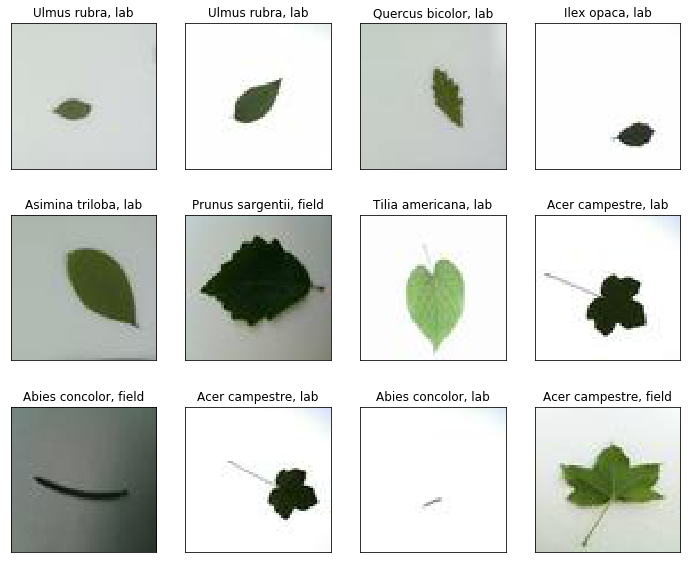

In [16]:
# plot random train images
d.plot_12images(images_train, labels_train, sources_train, figsize=(12,10))

### Data formatting

In [17]:
img_rows = 64
img_cols = 64
img_channels = 3
#print(K.image_data_format())
if K.image_data_format() == 'channels_first':
    images_train = images_train.reshape(images_train.shape[0], img_channels, img_rows, img_cols)
    images_test = images_test.reshape(images_test.shape[0], img_channels, img_rows, img_cols)
    images_val = images_val.reshape(images_val.shape[0], img_channels, img_rows, img_cols)
    input_shape = (img_channels, img_rows, img_cols)
else:
    images_train = images_train.reshape(images_train.shape[0], img_rows, img_cols, img_channels)
    images_test = images_test.reshape(images_test.shape[0], img_rows, img_cols, img_channels)
    images_val = images_val.reshape(images_val.shape[0], img_rows, img_cols, img_channels)
    input_shape = (img_rows, img_cols, img_channels)
print("Size of training data: ", np.shape(images_train))
print("Size of validation data: ", np.shape(images_val))
print("Size of testing data: ", np.shape(images_test))

Size of training data:  (4295, 64, 64, 3)
Size of validation data:  (1227, 64, 64, 3)
Size of testing data:  (614, 64, 64, 3)


## Construct the model

In [18]:
model = m.generate_model(input_shape, 30)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_layer1 (Conv2D)       (None, 60, 60, 32)        2432      
_________________________________________________________________
maxpooling2d_layer1 (MaxPool (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_layer2 (Conv2D)       (None, 26, 26, 64)        51264     
_________________________________________________________________
maxpooling2d_layer2 (MaxPool (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_layer1 (Dropout)     (None, 13, 13, 64)        0         
_________________________________________________________________
flatten_layer1 (Flatten)     (None, 10816)             0         
_________________________________________________________________
dense_layer1 (Dense)         (None, 1000)              10817000  
__________

### Train the model

In [19]:
from keras.callbacks import ModelCheckpoint

# autosave best Model
best_model_file = model_fname = os.path.join(original_data_path, 'Models','leafnet.h5')
best_model = ModelCheckpoint(best_model_file, monitor='val_loss', verbose=1, save_best_only=True)

print('Training model...')
batch_size = 32
epochs = 200
model, results = m.train_model(model, images_train, labels_one_hot_train,
                             images_val, labels_one_hot_val, 
                             batch_size, epochs, best_model)
print('Traing finished.')

print('Loading the best model...')
model = load_model(best_model_file)
print('Best Model loaded!')


Training model...
Train on 4295 samples, validate on 1227 samples
Epoch 1/200
4295/4295 [==============================] - 50s 12ms/step - loss: 3.2876 - acc: 0.0997 - val_loss: 3.0058 - val_acc: 0.1785

Epoch 00001: val_loss improved from inf to 3.00578, saving model to /home/elena/eStep/XAI/Data/LeafSnap/leafsnap-dataset-30subset/Models/leafnet.h5
Epoch 2/200
4295/4295 [==============================] - 54s 13ms/step - loss: 2.8833 - acc: 0.2075 - val_loss: 2.5197 - val_acc: 0.2893

Epoch 00002: val_loss improved from 3.00578 to 2.51975, saving model to /home/elena/eStep/XAI/Data/LeafSnap/leafsnap-dataset-30subset/Models/leafnet.h5
Epoch 3/200
4295/4295 [==============================] - 44s 10ms/step - loss: 2.5529 - acc: 0.2834 - val_loss: 2.6842 - val_acc: 0.2192

Epoch 00003: val_loss did not improve from 2.51975
Epoch 4/200
4295/4295 [==============================] - 44s 10ms/step - loss: 2.3367 - acc: 0.3388 - val_loss: 2.2939 - val_acc: 0.3635

Epoch 00004: val_loss improved 

4295/4295 [==============================] - 39s 9ms/step - loss: 0.7982 - acc: 0.7399 - val_loss: 1.5077 - val_acc: 0.5876

Epoch 00035: val_loss did not improve from 1.21906
Epoch 36/200
4295/4295 [==============================] - 39s 9ms/step - loss: 0.7932 - acc: 0.7525 - val_loss: 1.2977 - val_acc: 0.6170

Epoch 00036: val_loss did not improve from 1.21906
Epoch 37/200
4295/4295 [==============================] - 41s 10ms/step - loss: 0.7570 - acc: 0.7534 - val_loss: 1.2921 - val_acc: 0.6186

Epoch 00037: val_loss did not improve from 1.21906
Epoch 38/200
4295/4295 [==============================] - 39s 9ms/step - loss: 0.7552 - acc: 0.7651 - val_loss: 1.5158 - val_acc: 0.5526

Epoch 00038: val_loss did not improve from 1.21906
Epoch 39/200
4295/4295 [==============================] - 39s 9ms/step - loss: 0.7465 - acc: 0.7669 - val_loss: 1.2730 - val_acc: 0.6202

Epoch 00039: val_loss did not improve from 1.21906
Epoch 40/200
4295/4295 [==============================] - 38s 9ms/s

4295/4295 [==============================] - 41s 10ms/step - loss: 0.4626 - acc: 0.8554 - val_loss: 1.2599 - val_acc: 0.6740

Epoch 00076: val_loss did not improve from 1.10327
Epoch 77/200
4295/4295 [==============================] - 40s 9ms/step - loss: 0.4522 - acc: 0.8536 - val_loss: 1.3051 - val_acc: 0.6463

Epoch 00077: val_loss did not improve from 1.10327
Epoch 78/200
4295/4295 [==============================] - 40s 9ms/step - loss: 0.4410 - acc: 0.8647 - val_loss: 1.1604 - val_acc: 0.6593

Epoch 00078: val_loss did not improve from 1.10327
Epoch 79/200
4295/4295 [==============================] - 40s 9ms/step - loss: 0.4091 - acc: 0.8664 - val_loss: 1.4004 - val_acc: 0.6308

Epoch 00079: val_loss did not improve from 1.10327
Epoch 80/200
4295/4295 [==============================] - 40s 9ms/step - loss: 0.4148 - acc: 0.8622 - val_loss: 1.2191 - val_acc: 0.6862

Epoch 00080: val_loss did not improve from 1.10327
Epoch 81/200
4295/4295 [==============================] - 40s 9ms/s

4295/4295 [==============================] - 39s 9ms/step - loss: 0.3166 - acc: 0.9057 - val_loss: 1.2461 - val_acc: 0.6585

Epoch 00118: val_loss did not improve from 1.06217
Epoch 119/200
4295/4295 [==============================] - 38s 9ms/step - loss: 0.3016 - acc: 0.9013 - val_loss: 1.2788 - val_acc: 0.6528

Epoch 00119: val_loss did not improve from 1.06217
Epoch 120/200
4295/4295 [==============================] - 39s 9ms/step - loss: 0.2969 - acc: 0.9031 - val_loss: 1.2217 - val_acc: 0.7148

Epoch 00120: val_loss did not improve from 1.06217
Epoch 121/200
4295/4295 [==============================] - 38s 9ms/step - loss: 0.3076 - acc: 0.9031 - val_loss: 1.1930 - val_acc: 0.7001

Epoch 00121: val_loss did not improve from 1.06217
Epoch 122/200
4295/4295 [==============================] - 39s 9ms/step - loss: 0.3120 - acc: 0.9048 - val_loss: 1.2472 - val_acc: 0.7115

Epoch 00122: val_loss did not improve from 1.06217
Epoch 123/200
4295/4295 [==============================] - 39s 9

4295/4295 [==============================] - 39s 9ms/step - loss: 0.2581 - acc: 0.9227 - val_loss: 1.5079 - val_acc: 0.6838

Epoch 00161: val_loss did not improve from 1.06217
Epoch 162/200
4295/4295 [==============================] - 38s 9ms/step - loss: 0.2327 - acc: 0.9253 - val_loss: 1.4065 - val_acc: 0.7066

Epoch 00162: val_loss did not improve from 1.06217
Epoch 163/200
4295/4295 [==============================] - 38s 9ms/step - loss: 0.2680 - acc: 0.9213 - val_loss: 1.2693 - val_acc: 0.7074

Epoch 00163: val_loss did not improve from 1.06217
Epoch 164/200
4295/4295 [==============================] - 38s 9ms/step - loss: 0.2621 - acc: 0.9194 - val_loss: 1.6713 - val_acc: 0.6463

Epoch 00164: val_loss did not improve from 1.06217
Epoch 165/200
4295/4295 [==============================] - 38s 9ms/step - loss: 0.2617 - acc: 0.9208 - val_loss: 1.3380 - val_acc: 0.7237

Epoch 00165: val_loss did not improve from 1.06217
Epoch 166/200
4295/4295 [==============================] - 39s 9

### Test the model

In [20]:
score = model.evaluate(images_test, labels_one_hot_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.2491331081048673
Test accuracy: 0.7117263843648208


### Examine training process

In [21]:
print(results)

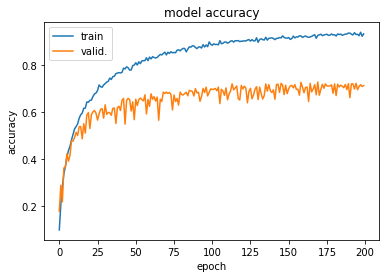

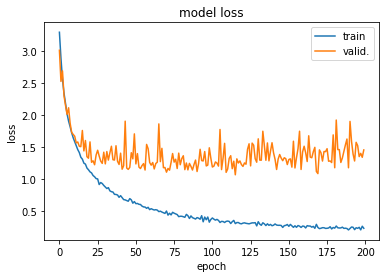

In [22]:
from matplotlib import pyplot as plt

# summarize history for accuracy
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid.'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid.'], loc='upper right')
plt.show()